In [1]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
clinical_data_path = '../Data/Raw_Data/Clinical_Data/'
output_path = '../Data/Processed_Data/'


df_methyl = pd.read_pickle(
    input_path+'df_batch_uncorrected.pkl').sort_index()

print(
    f' Dataset (df) contains {df_methyl.shape[1]} columns (5mC nucleotides/probes) and {df_methyl.shape[0]} rows (samples).')

# Import functions to clean up clinical data
from FM_Functions.Clinical_Data_CleanUp import *

# Call functions to merge, index and clean clinical data files
labels_0531         = clean_cog       (merge_index_0531())
labels_1031         = clean_cog       (merge_index_1031())
labels_aml05        = clean_aml05     (merge_index_aml05())
labels_beataml      = clean_beataml   (merge_index_beataml())
labels_amltcga      = clean_amltcga   (merge_index_amltcga())
labels_nordic_all   = clean_nordic_all(merge_index_nordic_all())
labels_mds_taml     = clean_mds_taml  (merge_index_mds_taml())
labels_all_graal    = clean_all_graal (merge_index_all_graal())
labels_target_all   = clean_target_all(merge_index_target_all())

# Combine all clinical data labels into one dataframe
labels_combined = pd.concat([labels_aml05, labels_beataml,
                         labels_0531, labels_amltcga, labels_1031,
                        labels_nordic_all, labels_mds_taml,
                        labels_all_graal,labels_target_all], axis=0, join='outer')

# read x_top from output file
x = pd.read_pickle(output_path+'ewas_dmr/ewas_top_x.pkl')

# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(x.index)].sort_index()

 Dataset (df) contains 333352 columns (5mC nucleotides/probes) and 3330 rows (samples).


In [3]:
# Import functions to clean up clinical data
from FM_Functions.Cox_Lasso_Function import *

## Perform Survival Analysis

In [4]:
# raw_coefs = train_coxph_lasso(df=df_labels,
#                                 event= 'os.evnt',
#                                 time= 'os.time',
#                                 train_x=x.iloc[:,:100],
#                                 cv_n_split=3,
#                                 loops=10)

# raw_coefs.to_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs.csv')
raw_coefs = pd.read_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs.csv', index_col=0)

### Set Threshold

In [5]:
mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.85)
mean_coefs                                

IlmnID
cg20219911    0.193547
cg17099306    0.105642
cg01543603    0.091378
cg10089193    0.083503
cg02678414    0.079688
cg05131266    0.077085
cg00192882    0.059155
cg08329113    0.027522
cg18072388    0.017603
cg07660635   -0.020918
cg25292309   -0.053502
cg20310759   -0.056282
cg06748884   -0.066351
cg04839706   -0.090482
cg14928764   -0.112784
cg08900363   -0.137103
dtype: float64

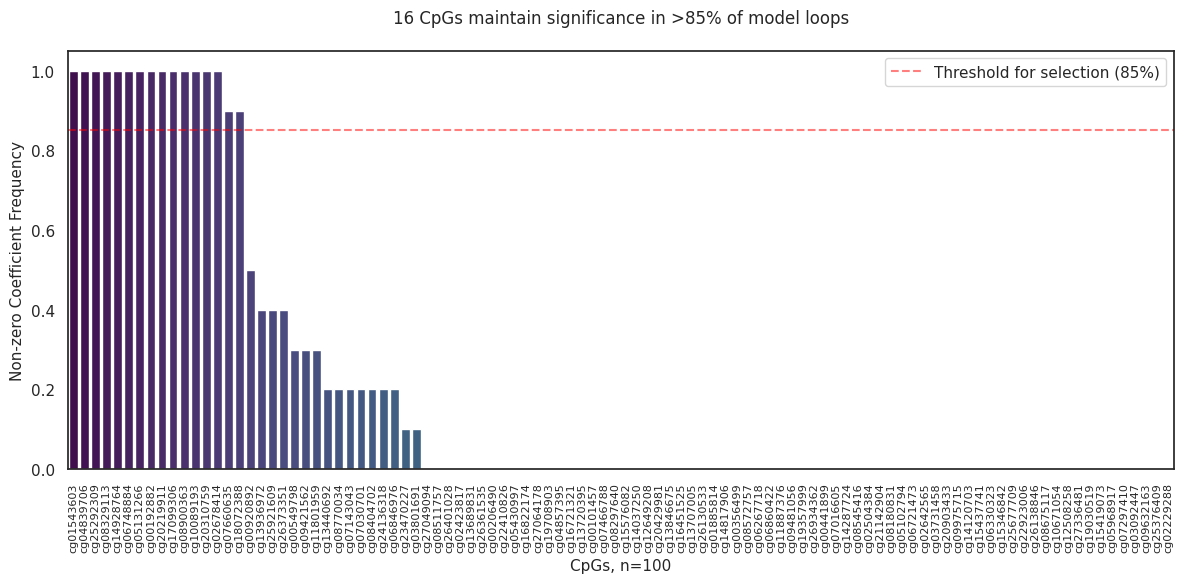

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.85, savefig=False, fig_path=None):
    sns.set_theme(style='white')

    # Larger figure size
    fig, ax = plt.subplots(figsize=(12,6))

    # Sorting the raw_coefs DataFrame by 'nonzero_freq'
    raw_coefs = raw_coefs.sort_values('nonzero_freq', ascending=False)

    # Plotting with a more pleasing color palette
    sns.barplot(x=raw_coefs.index, y=raw_coefs['nonzero_freq'], palette='viridis', ax=ax)

    # Adding y line
    plt.axhline(threshold, linestyle="--", color="red", label=f"Threshold for selection ({int(threshold*100)}%)",
                alpha=0.5)

    # Adding labels and title
    ax.set_xlabel("CpGs, n=" + str(len(raw_coefs)), fontsize=11)
    ax.set_ylabel("Non-zero Coefficient Frequency", fontsize=11)

    plt.title(f'{len(mean_coefs)} CpGs maintain significance in >{int(threshold*100)}% of model loops',
              pad=20)

    # Rotating x-axis labels for better readability if labels are overlapping
    plt.xticks(rotation=90, fontsize=8)

    # Legend
    plt.legend()

    # Tight layout
    plt.tight_layout()

    # Saving the figure
    if savefig and fig_path:
        plt.savefig(fig_path, bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()

plot_nonzero_coef_freq(raw_coefs, mean_coefs, savefig=False, fig_path=None)


## Generate Model Results

### Discovery Dataset

In [7]:
score_name = 'MethylScore_CoxPH'

In [8]:
df, methylscore_cutoff = generate_coxph_score(coef_mean=mean_coefs,
                                        x=x.iloc[:,:100],
                                        df=df_labels,
                                        score_name=score_name,
                                        train_test="train",
                                        cutoff_train=0.75)

Continuous score cut at the value of 0.4776


In [9]:
# Import Plotting Functions
from FM_Functions.Data_Visualization import *

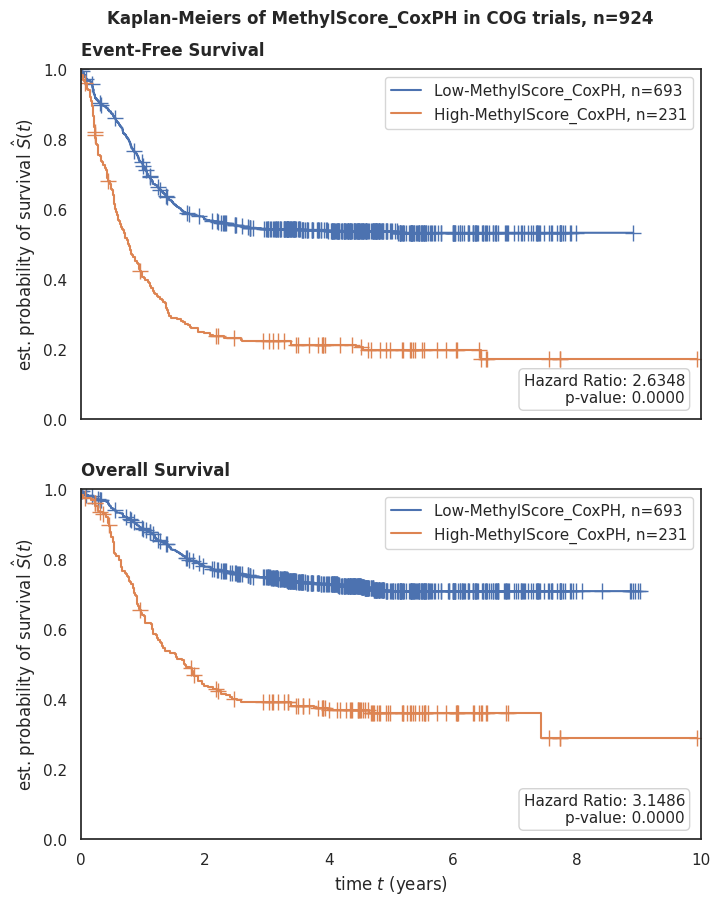

In [10]:
draw_kaplan_meier(scorename=score_name,
                        df=df,
                        save_plot=False,
                        add_risk_counts=False,
                        trialname='COG trials')

## Forest Plots

In [48]:
df_labels['MRD 1 Status'].value_counts(dropna=False)

# which `Clinical Trial` category the null values belong to
df_labels[df_labels['MRD 1 Status'].isnull()]['Clinical Trial'].value_counts(dropna=False)

Clinical Trial
AAML0531    88
AAML1031    22
AAML03P1     8
Name: count, dtype: int64

In [11]:
time='os.time'
event='os.evnt'
trialname='COG trials'
scorename=score_name

import statsmodels.formula.api as smf
import myforestplot as mfp
from tableone import TableOne
import statsmodels.formula.api as smf
import numpy as np

fp = df[[scorename+' Categorical',
            'Risk Group',
            'FLT3 ITD',
            'Leucocyte counts (10⁹/L)',
            'Age group (years)',
            time, event]].rename(columns={scorename + ' Categorical': scorename})
event2 = event.replace('.', '_')
time2 = time.replace('.', '_')

if event[0] == 'o':
    event3 = 'Overall-Survival'
    event4 = 'OS'
else:
    event3 = 'Event-Free Survival'
    event4 = 'EFS'
fp2 = fp.rename(columns={event: event2,
                            time: time2,
                            'FLT3 ITD': 'FLT3_ITD',
                            'Risk Group': 'Risk_Group',
                            'Leucocyte counts (10⁹/L)': 'WBC_count',
                            'Age group (years)': 'Age_group'})


res = smf.phreg(formula=time2 + " ~ C("+scorename+",Treatment(reference='Low')) + C(Risk_Group,Treatment(reference='Low Risk')) + FLT3_ITD + WBC_count + Age_group",
                data=fp2, status=event2).fit()

In [14]:

res2 = res.summary(xname=[scorename+'-High',
                              'Risk Group-High Risk',
                              'Risk Group-Standard Risk',
                              'FLT3 ITD-Yes',
                              'Leucocyte counts (10⁹/L)-≥30',
                              'Age group (years)-≥10']).tables[1]

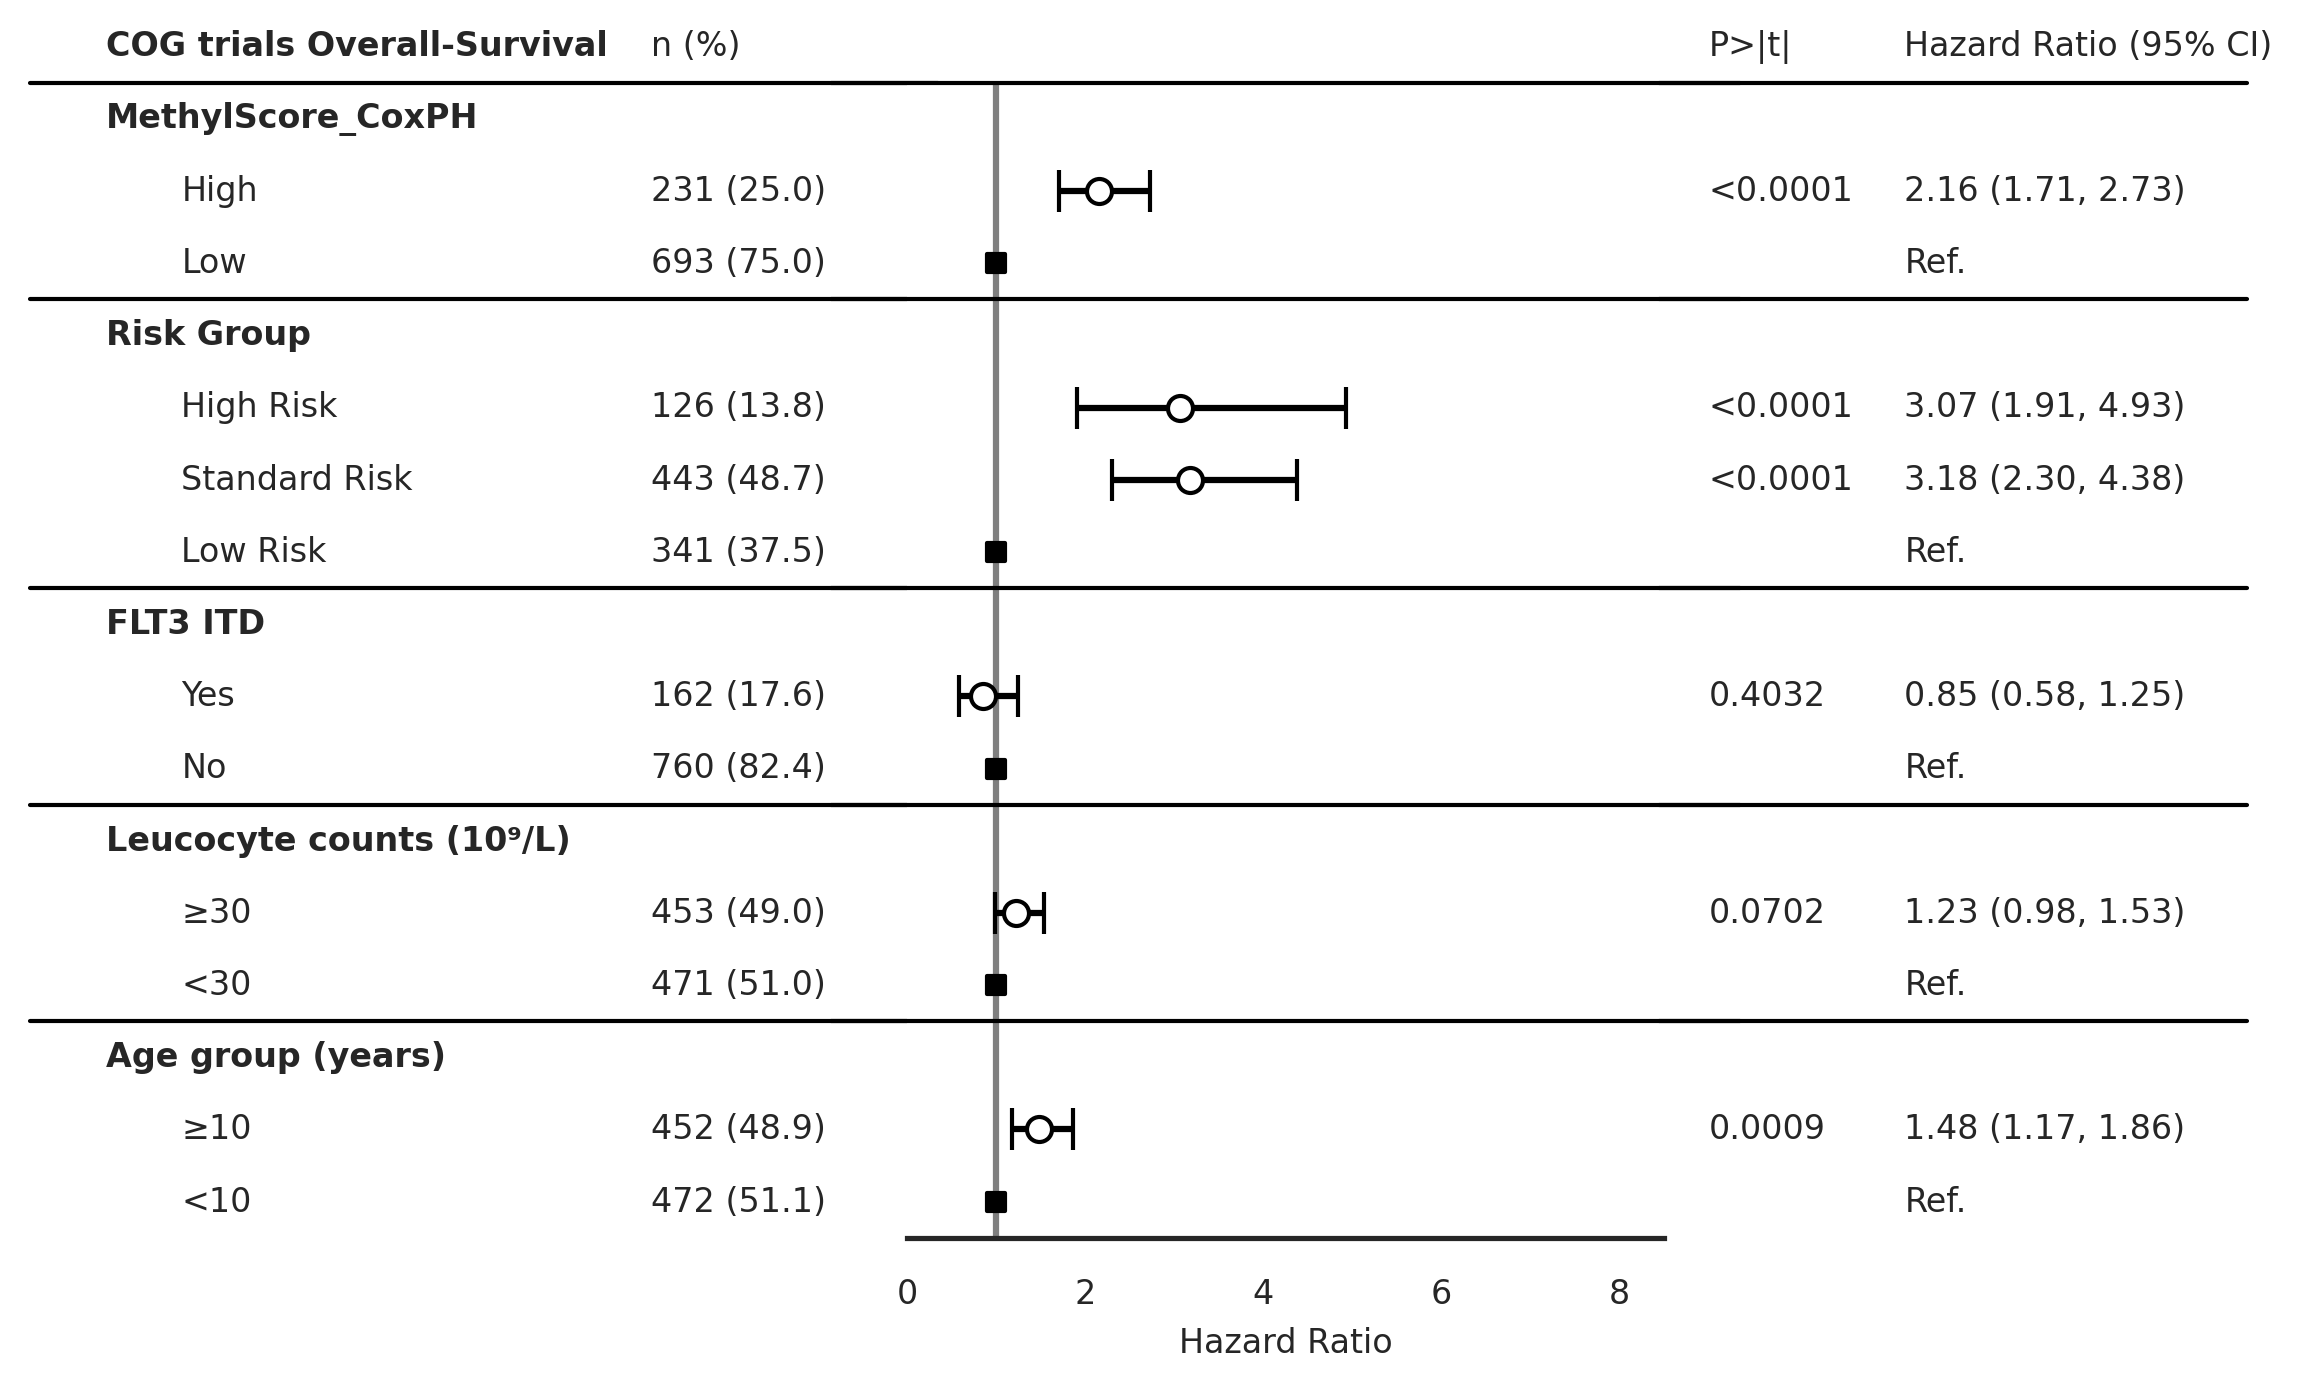

In [15]:

res3 = res2.set_index(res2.index.str.split(pat='-', expand=True))

mytable = TableOne(data=fp.drop(columns=[event, time]),
                    pval=False, missing=True, overall=True,
                    label_suffix=False, order={scorename: ['High'],
                                                'Risk Group': ['High Risk', 'Standard Risk'],
                                                'FLT3 ITD': ['Yes'],
                                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                                'Age group (years)': ['≥10']}).tableone

mytable2 = mytable.join(res3)

mytable2["risk_pretty"] = mfp.add_pretty_risk_column(mytable2,
                                                        risk="HR",
                                                        lower='[0.025',
                                                        upper='0.975]',
                                                        fml=".2f"
                                                        )
mytable3 = mytable2.reset_index(names=['category', 'item']).rename(columns={'HR': 'risk',
                                                                            '[0.025': 0,
                                                                            '0.975]': 1}).iloc[1:, :]

mytable3['P>|t|'] = round(mytable3['P>|t|'], 4).replace(
    {np.nan: '', 0: '<0.0001'})

plt.rcParams["font.size"] = 8
fp = mfp.ForestPlot(df=mytable3,
                    ratio=[3, 3, 2],
                    fig_ax_index=[2],
                    dpi=300,
                    figsize=(9, 5),
                    vertical_align=True)
fp.errorbar(index=2, errorbar_kwds=None)
fp.axd[2].set_xlim([1, 8.5])
fp.axd[2].set_xticks([0, 2, 4, 6, 8])
fp.axd[2].set_xticklabels(labels=[0, 2, 4, 6, 8], fontdict={'fontsize': 8})
fp.axd[2].set_xlabel("Hazard Ratio", fontsize=8)
fp.axd[2].axvline(x=1, ymin=0, ymax=1.0, color="black", alpha=0.5)

fp.axd[1].set_xlim([0.50, 1])
fp.embed_cate_strings(1, "category", 0.5, header=trialname + " " + event3,
                        text_kwds=dict(fontweight="bold"),
                        header_kwds=dict(fontweight="bold"),
                        )
fp.embed_strings(1, "item", 0.55, header="", replace={"age": ""})
fp.embed_strings(1, "Overall", 0.86, header="n (%)")
fp.embed_strings(3, "P>|t|", 0, header="P>|t|")
fp.embed_strings(3, "risk_pretty", 0.4, header="Hazard Ratio (95% CI)")
fp.horizontal_variable_separators()
fp.draw_outer_marker(log_scale=False, scale=0.008, index=2)

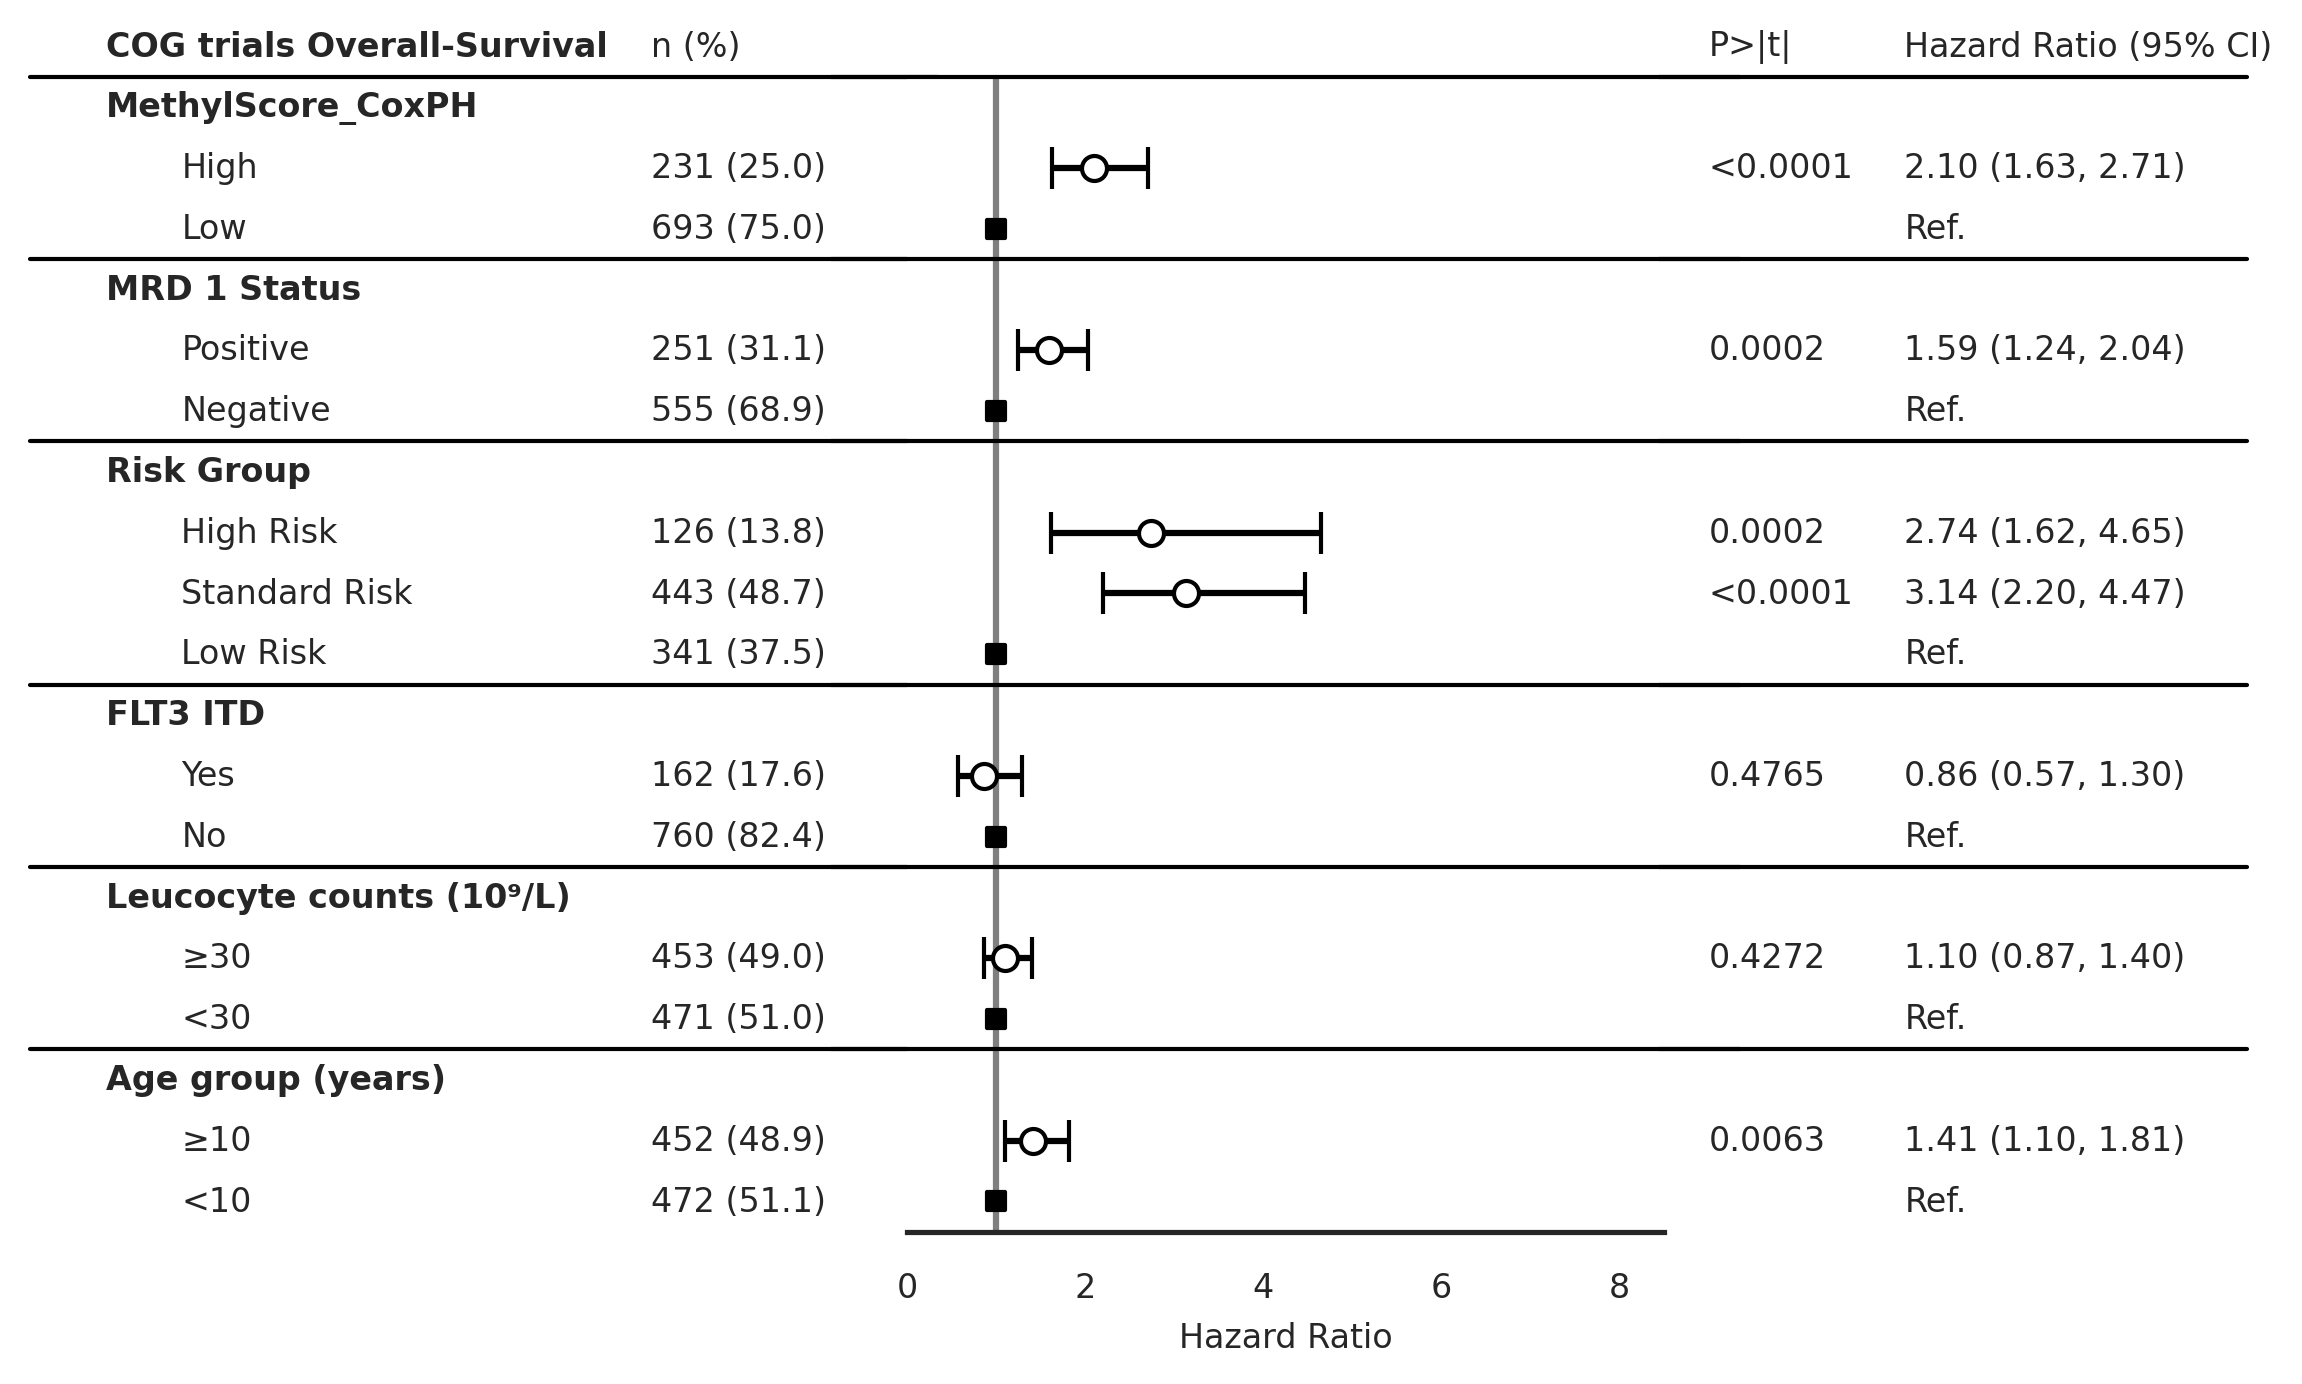

In [18]:
time='os.time'
event='os.evnt'
trialname='COG trials'
scorename=score_name

import statsmodels.formula.api as smf
import myforestplot as mfp
from tableone import TableOne
import statsmodels.formula.api as smf
import numpy as np

fp = df[[scorename+' Categorical',
            'MRD 1 Status',
            'Risk Group',
            'FLT3 ITD',
            'Leucocyte counts (10⁹/L)',
            'Age group (years)',
            time, event]].rename(columns={scorename + ' Categorical': scorename})
event2 = event.replace('.', '_')
time2 = time.replace('.', '_')

if event[0] == 'o':
    event3 = 'Overall-Survival'
    event4 = 'OS'
else:
    event3 = 'Event-Free Survival'
    event4 = 'EFS'
fp2 = fp.rename(columns={event: event2,
                            time: time2,
                            'MRD 1 Status': 'MRD_1_Status',
                            'FLT3 ITD': 'FLT3_ITD',
                            'Risk Group': 'Risk_Group',
                            'Leucocyte counts (10⁹/L)': 'WBC_count',
                            'Age group (years)': 'Age_group'})

# Count nan values in each column
nan_counts = fp2.isna().sum()
nan_counts
res = smf.phreg(formula=time2 + " ~ C("+scorename+",Treatment(reference='Low')) + C(MRD_1_Status,Treatment(reference='Negative')) + C(Risk_Group,Treatment(reference='Low Risk')) + C(FLT3_ITD) + C(WBC_count) + C(Age_group)",
                data=fp2, status=event2 ).fit()

res2 = res.summary(xname=[scorename+'-High',
                              'MRD 1 Status-Positive',
                              'Risk Group-High Risk',
                              'Risk Group-Standard Risk',
                              'FLT3 ITD-Yes',
                              'Leucocyte counts (10⁹/L)-≥30',
                              'Age group (years)-≥10']).tables[1]

res3 = res2.set_index(res2.index.str.split(pat='-', expand=True))

mytable = TableOne(data=fp.drop(columns=[event, time]),
                    pval=False, missing=True, overall=True,
                    label_suffix=False, order={scorename: ['High'],
                                                'MRD 1 Status': ['Positive'],
                                                'Risk Group': ['High Risk', 'Standard Risk'],
                                                'FLT3 ITD': ['Yes'],
                                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                                'Age group (years)': ['≥10']}).tableone

mytable2 = mytable.join(res3)

mytable2["risk_pretty"] = mfp.add_pretty_risk_column(mytable2,
                                                        risk="HR",
                                                        lower='[0.025',
                                                        upper='0.975]',
                                                        fml=".2f"
                                                        )
mytable3 = mytable2.reset_index(names=['category', 'item']).rename(columns={'HR': 'risk',
                                                                            '[0.025': 0,
                                                                            '0.975]': 1}).iloc[1:, :]

mytable3['P>|t|'] = round(mytable3['P>|t|'], 4).replace(
    {np.nan: '', 0: '<0.0001'})

plt.rcParams["font.size"] = 8
fp = mfp.ForestPlot(df=mytable3,
                    ratio=[3, 3, 2],
                    fig_ax_index=[2],
                    dpi=300,
                    figsize=(9, 5),
                    vertical_align=True)
fp.errorbar(index=2, errorbar_kwds=None)
fp.axd[2].set_xlim([1, 8.5])
fp.axd[2].set_xticks([0, 2, 4, 6, 8])
fp.axd[2].set_xticklabels(labels=[0, 2, 4, 6, 8], fontdict={'fontsize': 8})
fp.axd[2].set_xlabel("Hazard Ratio", fontsize=8)
fp.axd[2].axvline(x=1, ymin=0, ymax=1.0, color="black", alpha=0.5)

fp.axd[1].set_xlim([0.50, 1])
fp.embed_cate_strings(1, "category", 0.5, header=trialname + " " + event3,
                        text_kwds=dict(fontweight="bold"),
                        header_kwds=dict(fontweight="bold"),
                        )
fp.embed_strings(1, "item", 0.55, header="", replace={"age": ""})
fp.embed_strings(1, "Overall", 0.86, header="n (%)")
fp.embed_strings(3, "P>|t|", 0, header="P>|t|")
fp.embed_strings(3, "risk_pretty", 0.4, header="Hazard Ratio (95% CI)")
fp.horizontal_variable_separators()
fp.draw_outer_marker(log_scale=False, scale=0.008, index=2)

In [ ]:
res = smf.phreg(formula=time2 + " ~ C("+scorename+",Treatment(reference='Low')) + C(MRD_1_Status) + C(Risk_Group,Treatment(reference='Low Risk')) + C(FLT3_ITD) + C(WBC_count) + C(Age_group)",
                data=fp2, status=event2, penalize=0.1).fit()

In [34]:
fp2

,MethylScore_CoxPH,MRD_1_Status,Risk_Group,FLT3_ITD,WBC_count,Age_group,os_time,os_evnt
Sample_ID,,,,,,,,
0003fe29-7b8f-4ef1-b9bc-40306205f1fd_noid,High,NaN,Standard Risk,No,≥30,≥10,1.153425,1.0
0066d4af-8019-46a0-ba29-d2962c9537a7_noid,Low,Positive,High Risk,Yes,<30,≥10,0.808219,0.0
02b94d3d-2b6f-4c7a-9554-8e6256ddc791_noid,High,Positive,Standard Risk,No,≥30,≥10,0.238356,1.0
07cc5884-1128-459f-9a13-f2c004b60b86_noid,Low,Negative,Low Risk,No,≥30,≥10,1.454795,1.0
09188087-8ca5-4841-8061-b5010da37283_noid,Low,Positive,Standard Risk,No,<30,<10,4.871233,0.0
...,...,...,...,...,...,...,...,...
e036c3cb-a36b-4626-9c94-eb79067a129d_noid,Low,Positive,High Risk,Yes,≥30,<10,0.756164,1.0
e844b417-c4ad-41db-b361-e93e3c88d3f3_noid,High,Positive,Standard Risk,No,≥30,<10,4.547945,0.0
f30fb61d-b08c-4e74-aa50-3a3f0fee6b03_noid,Low,Negative,High Risk,Yes,≥30,≥10,5.608219,0.0


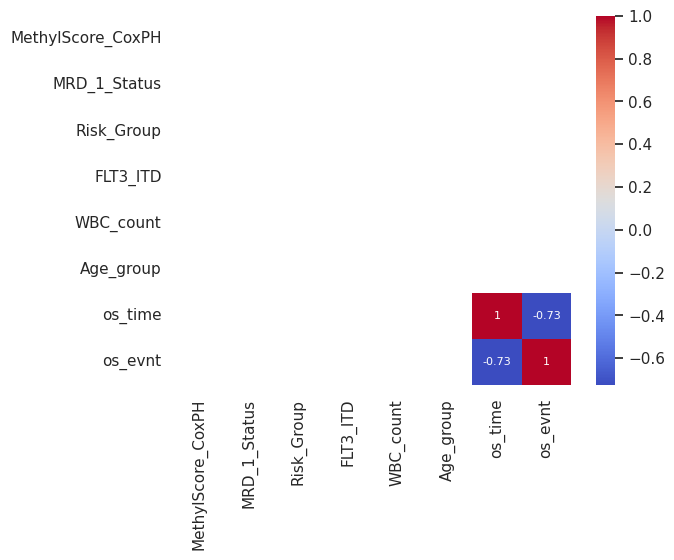

MissingDataError: exog contains inf or nans

In [20]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert non-numeric columns to appropriate data types
fp2 = fp2.apply(pd.to_numeric, errors='coerce')

# Exclude non-numeric columns from correlation calculation
numeric_df = fp2.select_dtypes(include='number')

# Interpolate missing values
numeric_df = numeric_df.interpolate()

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Visualize correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

# Calculate VIF
X = sm.add_constant(fp2)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif)

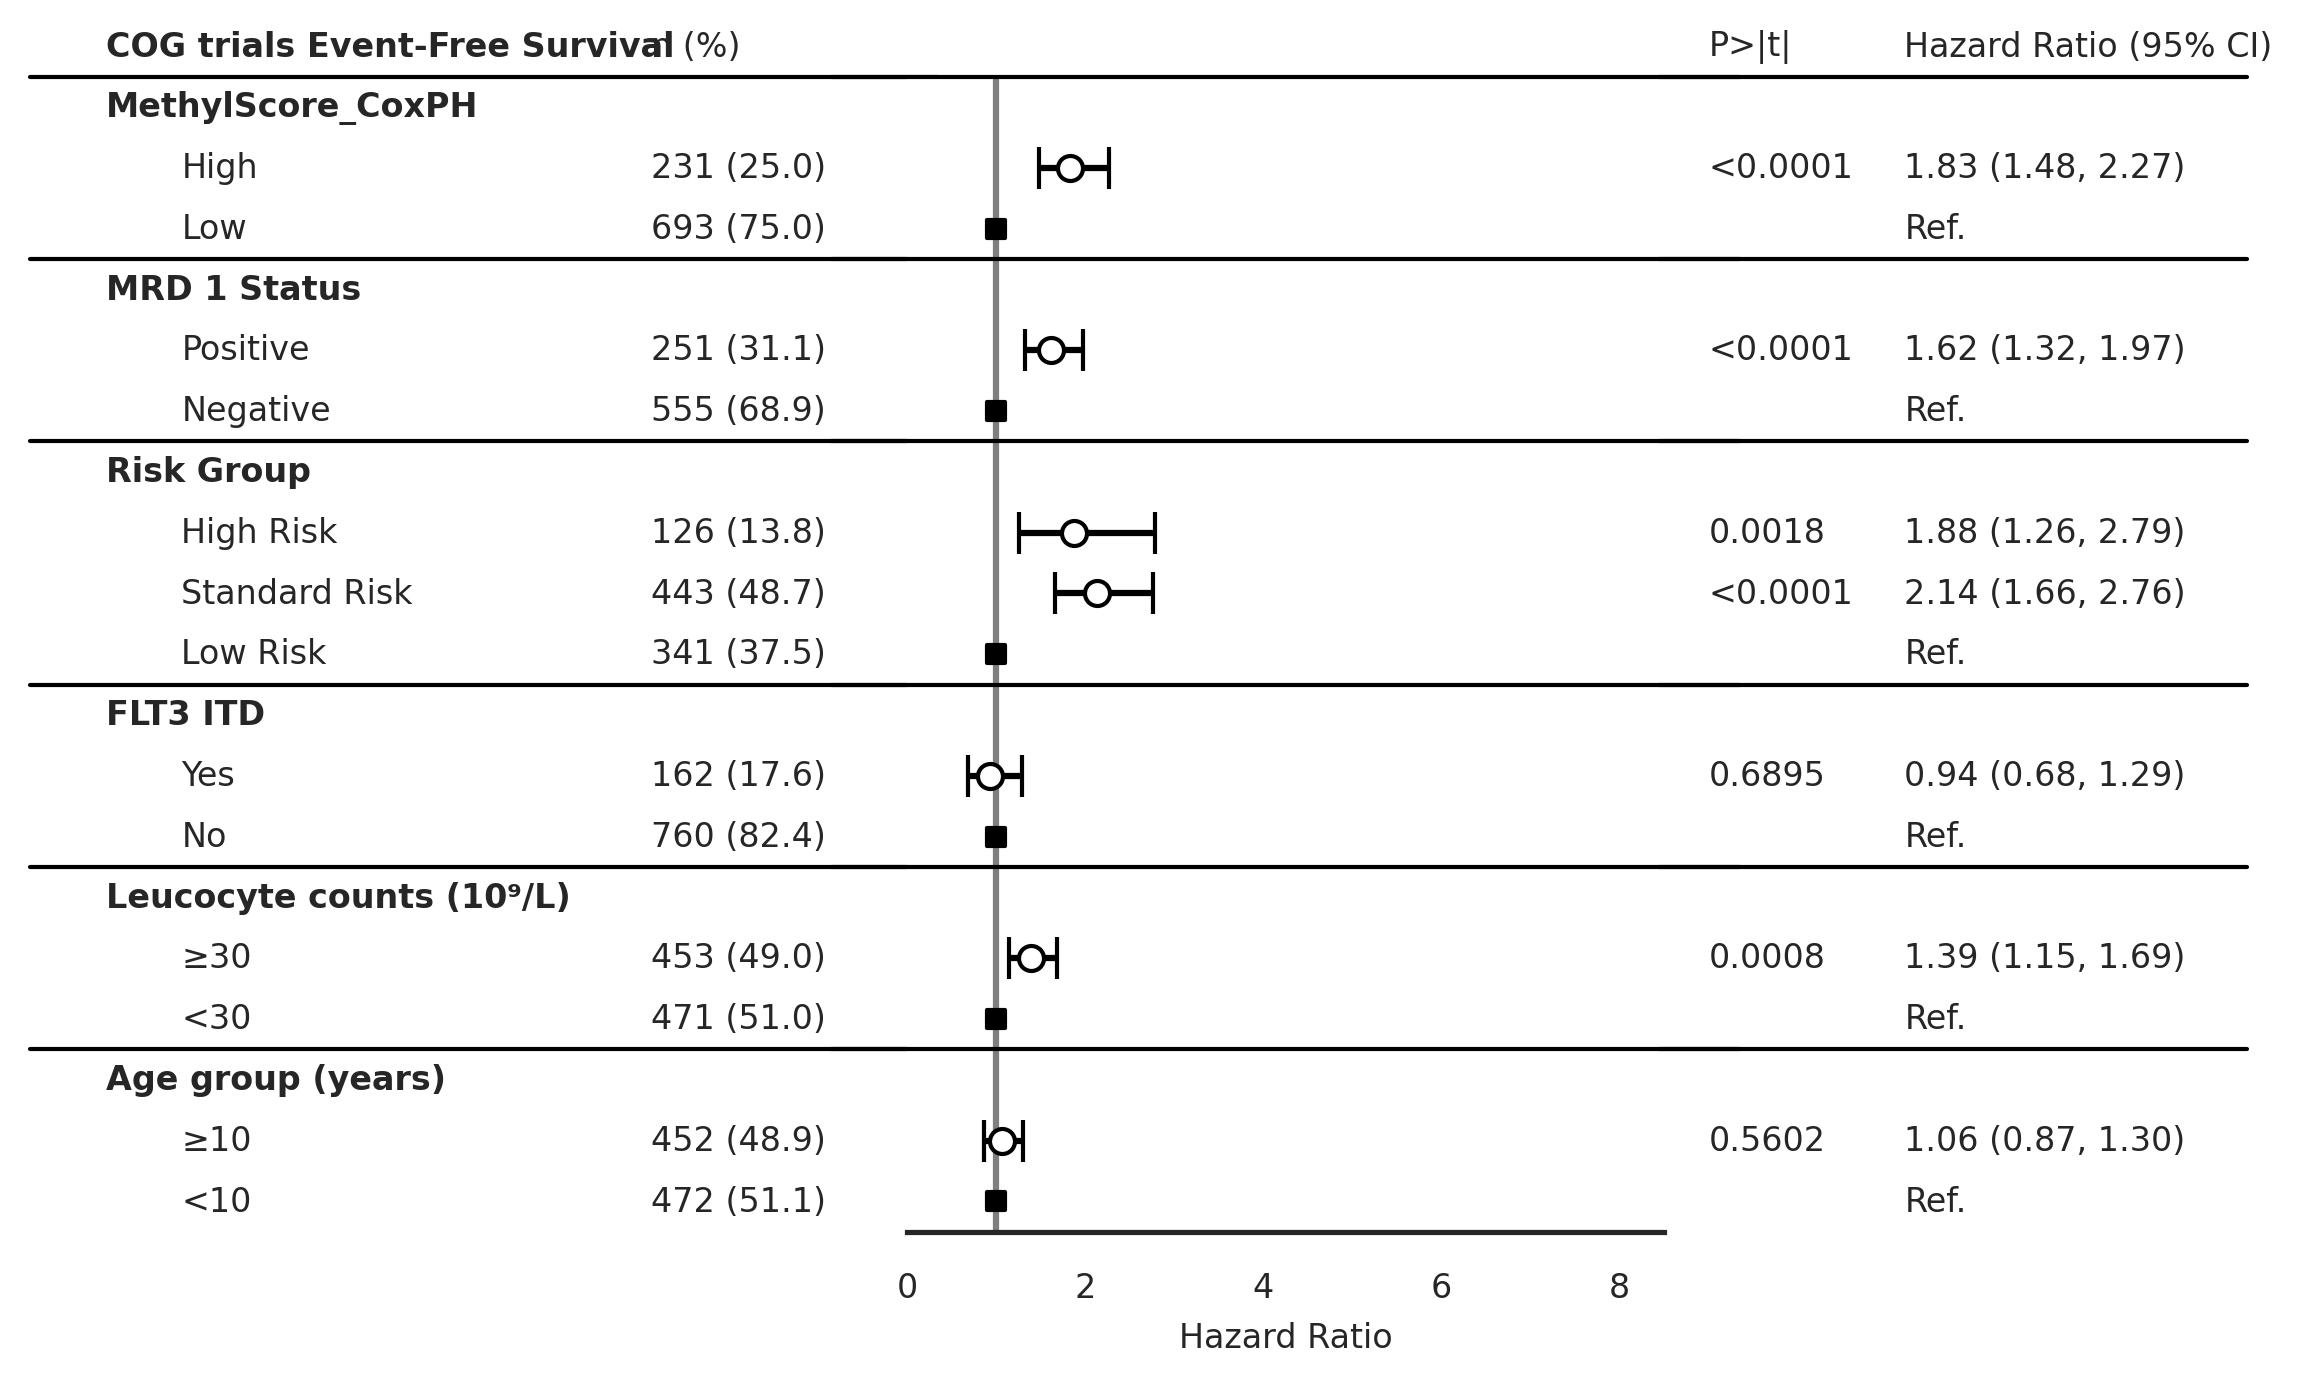

In [22]:
draw_forest_plot(time='efs.time',
                    event='efs.evnt',
                    df=df,
                    trialname='COG trials',
                    scorename=score_name,
                    save_plot=False)

In [22]:
draw_forest_plot(time='os.time',
                    event='os.evnt',
                    df=df,
                    trialname='COG trials',
                    scorename=score_name,
                    save_plot=False)


LinAlgError: Singular matrix